In [19]:
!pip install datasets torchsummary -q

In [20]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import make_grid
from tqdm import tqdm
from datasets import load_dataset
import os

torch.manual_seed(42)
np.random.seed(42)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 64
BATCH_SIZE = 128
NOISE_DIM = 100
EMBED_DIM = 50
NUM_CLASSES = 101
LR_G = 0.0002
LR_D = 0.0002
BETA_1 = 0.5
BETA_2 = 0.999
EPOCHS = 5
NUM_SAMPLES = 75750

print(f"Device: {device}")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Device: cuda
Image Size: 64x64
Number of Classes: 101


In [22]:
print("Loading Food-101 dataset...")
hf_dataset = load_dataset("food101", split="train")
hf_dataset = hf_dataset.shuffle(seed=42)

LABEL_NAMES = hf_dataset.features["label"].names

label_to_idx = {name: idx for idx, name in enumerate(LABEL_NAMES)}
idx_to_label = {idx: name for idx, name in enumerate(LABEL_NAMES)}

print(f"Total samples: {len(hf_dataset)}")
print(f"\n Food Categories ({NUM_CLASSES} total)")
print(LABEL_NAMES[:20])
print("...")

Loading Food-101 dataset...
Total samples: 75750

=== Food Categories (101 total) ===
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla']
...


In [23]:
print("\nFood Categories ")
for i, name in enumerate(LABEL_NAMES):
    print(f"{i:3d}: {name}", end="\t")
    if (i + 1) % 4 == 0:
        print()


Food Categories 
  0: apple_pie	  1: baby_back_ribs	  2: baklava	  3: beef_carpaccio	
  4: beef_tartare	  5: beet_salad	  6: beignets	  7: bibimbap	
  8: bread_pudding	  9: breakfast_burrito	 10: bruschetta	 11: caesar_salad	
 12: cannoli	 13: caprese_salad	 14: carrot_cake	 15: ceviche	
 16: cheesecake	 17: cheese_plate	 18: chicken_curry	 19: chicken_quesadilla	
 20: chicken_wings	 21: chocolate_cake	 22: chocolate_mousse	 23: churros	
 24: clam_chowder	 25: club_sandwich	 26: crab_cakes	 27: creme_brulee	
 28: croque_madame	 29: cup_cakes	 30: deviled_eggs	 31: donuts	
 32: dumplings	 33: edamame	 34: eggs_benedict	 35: escargots	
 36: falafel	 37: filet_mignon	 38: fish_and_chips	 39: foie_gras	
 40: french_fries	 41: french_onion_soup	 42: french_toast	 43: fried_calamari	
 44: fried_rice	 45: frozen_yogurt	 46: garlic_bread	 47: gnocchi	
 48: greek_salad	 49: grilled_cheese_sandwich	 50: grilled_salmon	 51: guacamole	
 52: gyoza	 53: hamburger	 54: hot_and_sour_soup	 55: hot_dog

In [24]:
train_transforms = T.Compose([
    T.Lambda(lambda img: img.convert("RGB")),
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class FoodDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, max_samples=None):
        if max_samples:
            self.data = hf_dataset.select(range(min(max_samples, len(hf_dataset))))
        else:
            self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        label = self.data[idx]["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

trainset = FoodDataset(hf_dataset, transform=train_transforms, max_samples=NUM_SAMPLES)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

print(f"Dataset size: {len(trainset)}")
print(f"Number of batches: {len(trainloader)}")

Dataset size: 75750
Number of batches: 592


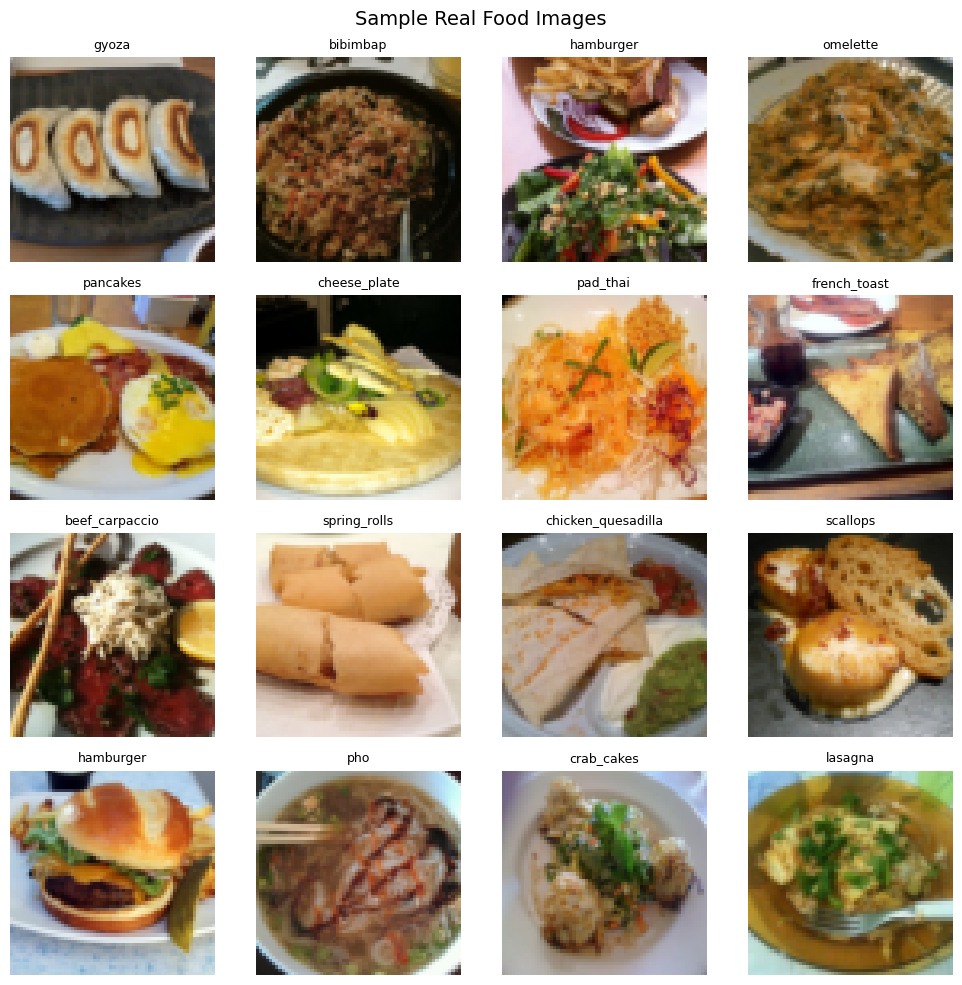

In [25]:
def show_tensor_images(tensor_img, num_images=16, nrow=4, figsize=(10, 10), title=None, labels=None):
    tensor_img = tensor_img.detach().cpu()
    tensor_img = (tensor_img + 1) / 2
    tensor_img = torch.clamp(tensor_img, 0, 1)

    if labels is not None:
        n = min(num_images, len(tensor_img))
        ncols = nrow
        nrows = (n + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten() if nrows > 1 else [axes] if ncols == 1 else axes

        for i in range(n):
            img = tensor_img[i].permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].set_title(labels[i] if i < len(labels) else "", fontsize=9)
            axes[i].axis('off')

        for i in range(n, len(axes)):
            axes[i].axis('off')

        if title:
            fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        img_grid = make_grid(tensor_img[:num_images], nrow=nrow, padding=2)
        plt.figure(figsize=figsize)
        if title:
            plt.title(title, fontsize=14)
        plt.imshow(img_grid.permute(1, 2, 0))
        plt.axis("off")
        plt.show()

sample_images, sample_labels = next(iter(trainloader))
sample_label_names = [idx_to_label[l.item()] for l in sample_labels[:16]]
show_tensor_images(sample_images, num_images=16, labels=sample_label_names, title="Sample Real Food Images")

In [26]:
def get_gen_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

In [27]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, num_classes, embed_dim):
        super(ConditionalGenerator, self).__init__()

        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim

        self.label_embedding = nn.Embedding(num_classes, embed_dim)
        self.input_dim = noise_dim + embed_dim

        self.project = nn.Sequential(
            nn.Linear(self.input_dim, 512 * 4 * 4, bias=False),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(inplace=True)
        )

        self.block_1 = get_gen_block(512, 256)
        self.block_2 = get_gen_block(256, 128)
        self.block_3 = get_gen_block(128, 64)
        self.block_4 = get_gen_block(64, 3, final_block=True)

    def forward(self, noise, labels):
        label_embed = self.label_embedding(labels)
        x = torch.cat([noise, label_embed], dim=1)

        x = self.project(x)
        x = x.view(-1, 512, 4, 4)

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        return x

In [28]:
def get_disc_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    ]
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))

    return nn.Sequential(*layers)

In [29]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, image_size=64):
        super(ConditionalDiscriminator, self).__init__()

        self.num_classes = num_classes
        self.image_size = image_size

        self.label_embedding = nn.Embedding(num_classes, image_size * image_size)

        self.block_1 = get_disc_block(4, 64, batch_norm=False)
        self.block_2 = get_disc_block(64, 128)
        self.block_3 = get_disc_block(128, 256)
        self.block_4 = get_disc_block(256, 512)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512, 1)

    def forward(self, images, labels):
        batch_size = images.size(0)

        label_embed = self.label_embedding(labels)
        label_embed = label_embed.view(batch_size, 1, self.image_size, self.image_size)

        x = torch.cat([images, label_embed], dim=1)

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        x = self.pool(x)
        x = self.flatten(x)

        return x

In [30]:
G = ConditionalGenerator(NOISE_DIM, NUM_CLASSES, EMBED_DIM).to(device)
D = ConditionalDiscriminator(NUM_CLASSES, IMAGE_SIZE).to(device)

print(" Conditional Generator ")
print(f"Input: noise ({NOISE_DIM}) + label embedding ({EMBED_DIM}) = {NOISE_DIM + EMBED_DIM}")
print(f"Output: 3 x {IMAGE_SIZE} x {IMAGE_SIZE} image")
print(f"Total parameters: {sum(p.numel() for p in G.parameters()):,}")

print("\n Conditional Discriminator ")
print(f"Input: 3 x {IMAGE_SIZE} x {IMAGE_SIZE} image + 1 x {IMAGE_SIZE} x {IMAGE_SIZE} label = 4 channels")
print(f"Output: 1 (real/fake logit)")
print(f"Total parameters: {sum(p.numel() for p in D.parameters()):,}")

 Conditional Generator 
Input: noise (100) + label embedding (50) = 150
Output: 3 x 64 x 64 image
Total parameters: 4,006,714

 Conditional Discriminator 
Input: 3 x 64 x 64 image + 1 x 64 x 64 label = 4 channels
Output: 1 (real/fake logit)
Total parameters: 3,172,609


In [31]:
test_noise = torch.randn(4, NOISE_DIM, device=device)
test_labels = torch.randint(0, NUM_CLASSES, (4,), device=device)

with torch.no_grad():
    test_output = G(test_noise, test_labels)
    test_pred = D(test_output, test_labels)

print(f"Generator output shape: {test_output.shape}")
print(f"Discriminator output shape: {test_pred.shape}")
print("Forward pass successful!")

Generator output shape: torch.Size([4, 3, 64, 64])
Discriminator output shape: torch.Size([4, 512])
Forward pass successful!


In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

G.apply(weights_init)
D.apply(weights_init)
print("Weights initialized!")

✓ Weights initialized!


In [33]:
criterion = nn.BCEWithLogitsLoss()

def real_loss(disc_pred, smooth=True):
    if smooth:
        labels = torch.empty_like(disc_pred).uniform_(0.9, 1.0)
    else:
        labels = torch.ones_like(disc_pred)
    return criterion(disc_pred, labels)

def fake_loss(disc_pred, smooth=True):
    if smooth:
        labels = torch.empty_like(disc_pred).uniform_(0.0, 0.1)
    else:
        labels = torch.zeros_like(disc_pred)
    return criterion(disc_pred, labels)

## 7. Setup Optimizers

In [34]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA_1, BETA_2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA_1, BETA_2))

print(f"Generator optimizer: Adam (lr={LR_G})")
print(f"Discriminator optimizer: Adam (lr={LR_D})")

Generator optimizer: Adam (lr=0.0002)
Discriminator optimizer: Adam (lr=0.0002)


In [35]:
def generate_noise(batch_size, noise_dim, device):
    return torch.randn(batch_size, noise_dim, device=device)

fixed_noise = generate_noise(16, NOISE_DIM, device)
fixed_labels = torch.arange(16, device=device) % NUM_CLASSES

history = {'d_loss': [], 'g_loss': []}

Starting Conditional GAN Training
Epochs: 5 | Batch size: 128 | Device: cuda


Epoch 1/5:  73%|███████▎  | 434/592 [04:56<01:28,  1.79it/s, D=0.6856, G=0.6111]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1/5: 100%|██████████| 592/592 [06:42<00:00,  1.47it/s, D=0.6897, G=0.6147]



Epoch [1/5] | D_loss: 0.6903 | G_loss: 0.5932


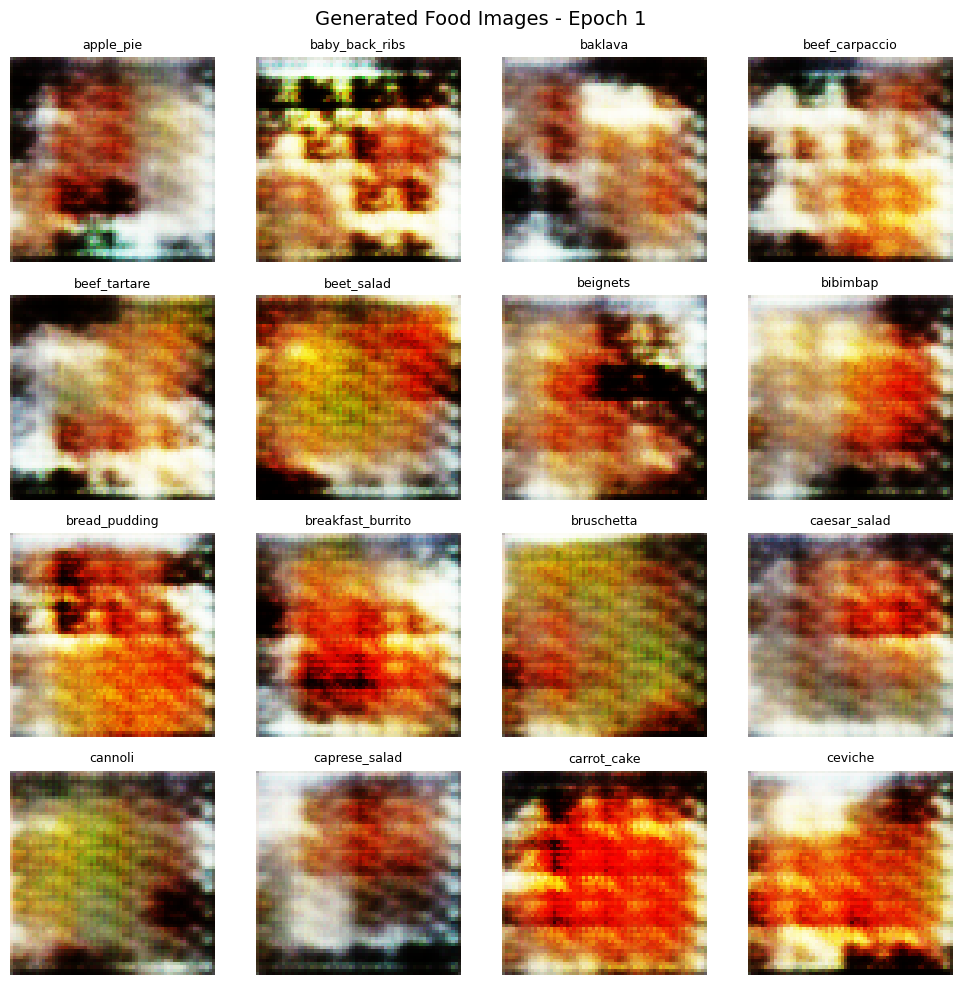

Epoch 2/5:   7%|▋         | 40/592 [00:27<05:59,  1.54it/s, D=0.6897, G=0.6202]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 2/5: 100%|██████████| 592/592 [06:34<00:00,  1.50it/s, D=0.6826, G=0.6380]



Epoch [2/5] | D_loss: 0.6872 | G_loss: 0.6202


Epoch 3/5:  78%|███████▊  | 463/592 [05:08<01:09,  1.85it/s, D=0.6857, G=0.6508]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 3/5: 100%|██████████| 592/592 [06:33<00:00,  1.50it/s, D=0.6868, G=0.6565]



Epoch [3/5] | D_loss: 0.6834 | G_loss: 0.6444


Epoch 4/5:  46%|████▌     | 272/592 [03:00<02:55,  1.82it/s, D=0.6841, G=0.6332]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 4/5: 100%|██████████| 592/592 [06:32<00:00,  1.51it/s, D=0.6777, G=0.6653]



Epoch [4/5] | D_loss: 0.6803 | G_loss: 0.6555


Epoch 5/5:  20%|█▉        | 116/592 [01:16<04:15,  1.86it/s, D=0.6804, G=0.6647]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 5/5: 100%|██████████| 592/592 [06:23<00:00,  1.54it/s, D=0.6756, G=0.6699]



Epoch [5/5] | D_loss: 0.6793 | G_loss: 0.6639


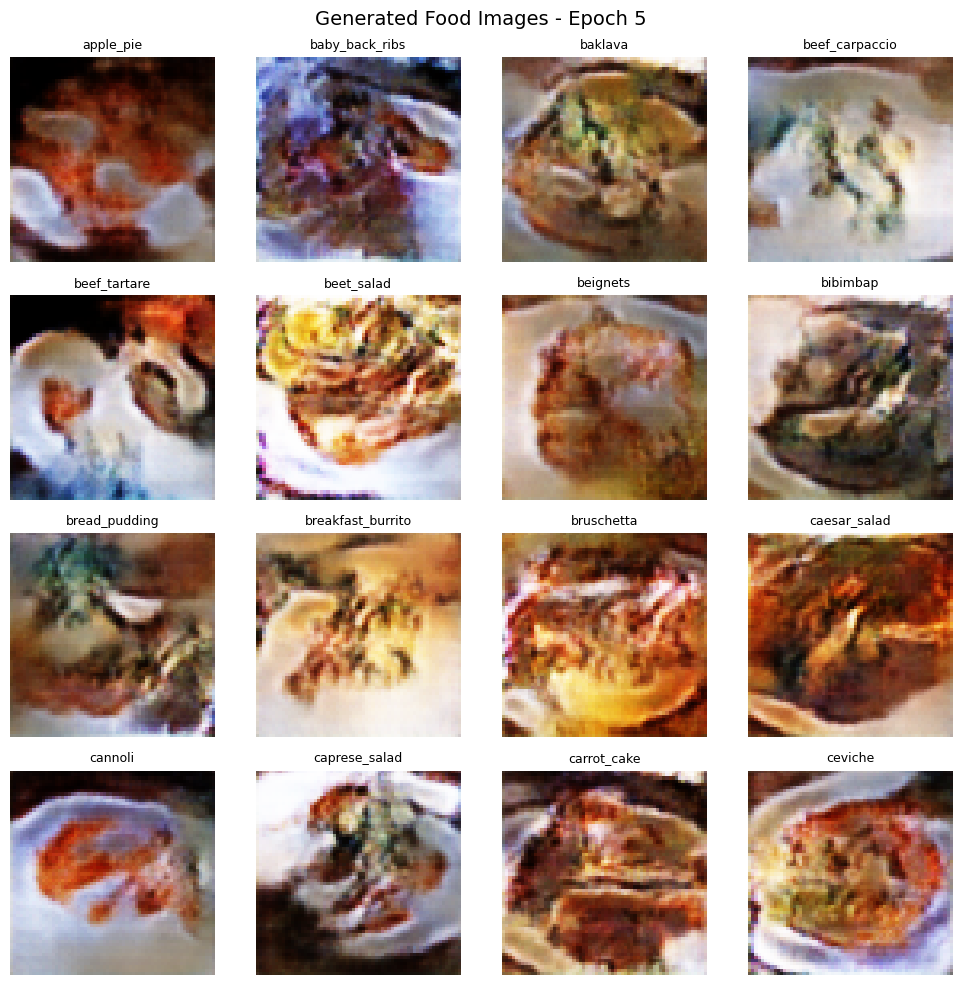


Training Complete!


In [36]:
print("="*60)
print("Starting Conditional GAN Training")
print(f"Epochs: {EPOCHS} | Batch size: {BATCH_SIZE} | Device: {device}")

for epoch in range(EPOCHS):
    G.train()
    D.train()

    total_d_loss = 0.0
    total_g_loss = 0.0

    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (real_images, real_labels) in enumerate(progress_bar):
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        batch_size = real_images.size(0)

        D_optimizer.zero_grad()

        real_pred = D(real_images, real_labels)
        d_real_loss = real_loss(real_pred, smooth=True)

        noise = generate_noise(batch_size, NOISE_DIM, device)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
        fake_images = G(noise, fake_labels).detach()
        fake_pred = D(fake_images, fake_labels)
        d_fake_loss = fake_loss(fake_pred, smooth=True)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        D_optimizer.step()

        G_optimizer.zero_grad()

        noise = generate_noise(batch_size, NOISE_DIM, device)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
        fake_images = G(noise, fake_labels)
        fake_pred = D(fake_images, fake_labels)

        g_loss = real_loss(fake_pred, smooth=False)
        g_loss.backward()
        G_optimizer.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

        progress_bar.set_postfix({'D': f'{d_loss.item():.4f}', 'G': f'{g_loss.item():.4f}'})

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)
    history['d_loss'].append(avg_d_loss)
    history['g_loss'].append(avg_g_loss)

    print(f"\nEpoch [{epoch+1}/{EPOCHS}] | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    if (epoch + 1) % 5 == 0 or epoch == 0:
        G.eval()
        with torch.no_grad():
            fake_samples = G(fixed_noise, fixed_labels)
            sample_labels = [idx_to_label[l.item()] for l in fixed_labels]
            show_tensor_images(fake_samples, num_images=16, labels=sample_labels,
                              title=f"Generated Food Images - Epoch {epoch+1}")

print("\n")
print("\n")
print("Training Complete!")
print("\n")
print("\n")


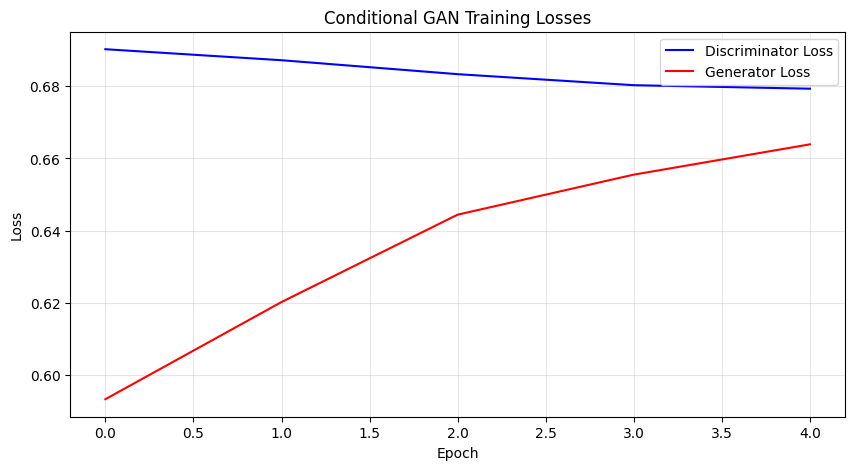

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(history['d_loss'], label='Discriminator Loss', color='blue')
plt.plot(history['g_loss'], label='Generator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Conditional GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
def generate_food_image(category_name, num_images=4):

    category_name = category_name.lower().strip().replace(' ', '_')

    if category_name not in label_to_idx:
        print(f" Category '{category_name}' not found!")
        print("\nAvailable categories:")
        for i, name in enumerate(LABEL_NAMES):
            print(f"  {name}", end="")
            if (i + 1) % 5 == 0:
                print()
        return None

    class_idx = label_to_idx[category_name]

    G.eval()
    with torch.no_grad():
        noise = generate_noise(num_images, NOISE_DIM, device)
        labels = torch.full((num_images,), class_idx, dtype=torch.long, device=device)
        generated_images = G(noise, labels)

    return generated_images, category_name


def interactive_generate():

    print("\n")
    print("CONDITIONAL GAN FOOD IMAGE GENERATOR ")
    print("\nAvailable food categories:")
    for i, name in enumerate(LABEL_NAMES):
        print(f"{i:3d}: {name:25s}", end="")
        if (i + 1) % 3 == 0:
            print()
    print("\n")

    user_input = input("Enter food category name (e.g., 'pizza', 'sushi', 'ice_cream'): ")
    num_images = int(input("How many images to generate? (1-16): "))
    num_images = min(max(num_images, 1), 16)

    result = generate_food_image(user_input, num_images)

    if result is not None:
        images, category = result
        print(f"\nGenerated {num_images} unique '{category}' images!")
        print("(These are NEW images, not from the dataset)\n")

        nrow = min(4, num_images)
        labels = [category] * num_images
        show_tensor_images(images, num_images=num_images, nrow=nrow,
                          labels=labels, figsize=(12, 12),
                          title=f"Generated {category.replace('_', ' ').title()} Images")

Generating images for multiple food categories...



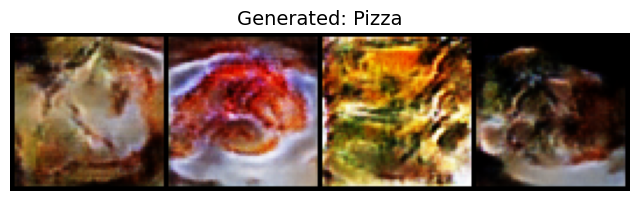

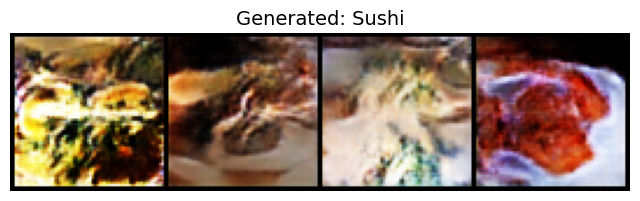

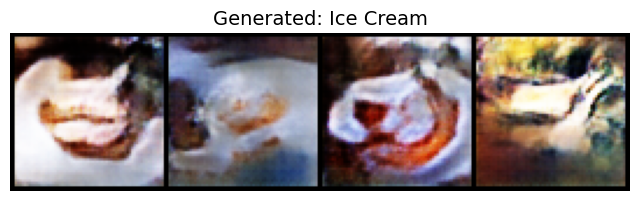

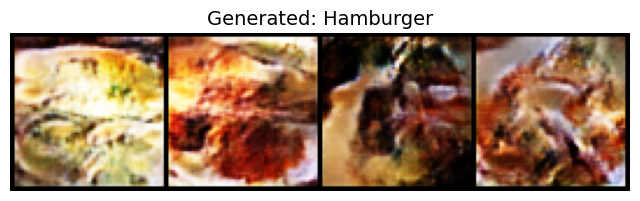

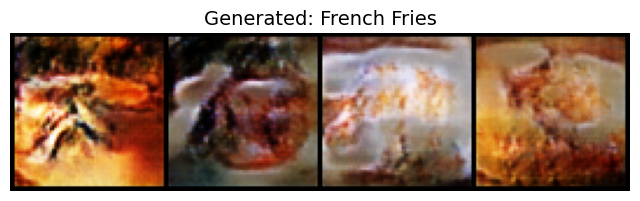

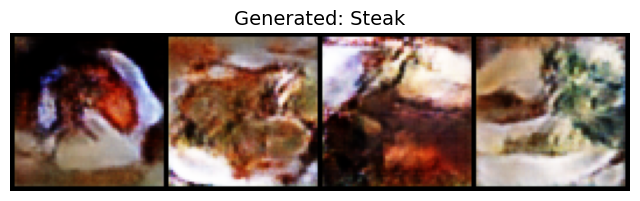

In [40]:
categories_to_generate = ['pizza', 'sushi', 'ice_cream', 'hamburger', 'french_fries', 'steak']

print("Generating images for multiple food categories\n")

for category in categories_to_generate:
    result = generate_food_image(category, num_images=4)
    if result is not None:
        images, cat_name = result
        show_tensor_images(images, num_images=4, nrow=4, figsize=(8, 3),
                          title=f"Generated: {cat_name.replace('_', ' ').title()}")

/tmp/ipython-input-3840685790.py:25: UserWarning: Glyph 127856 (\N{SHORTCAKE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127856 (\N{SHORTCAKE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


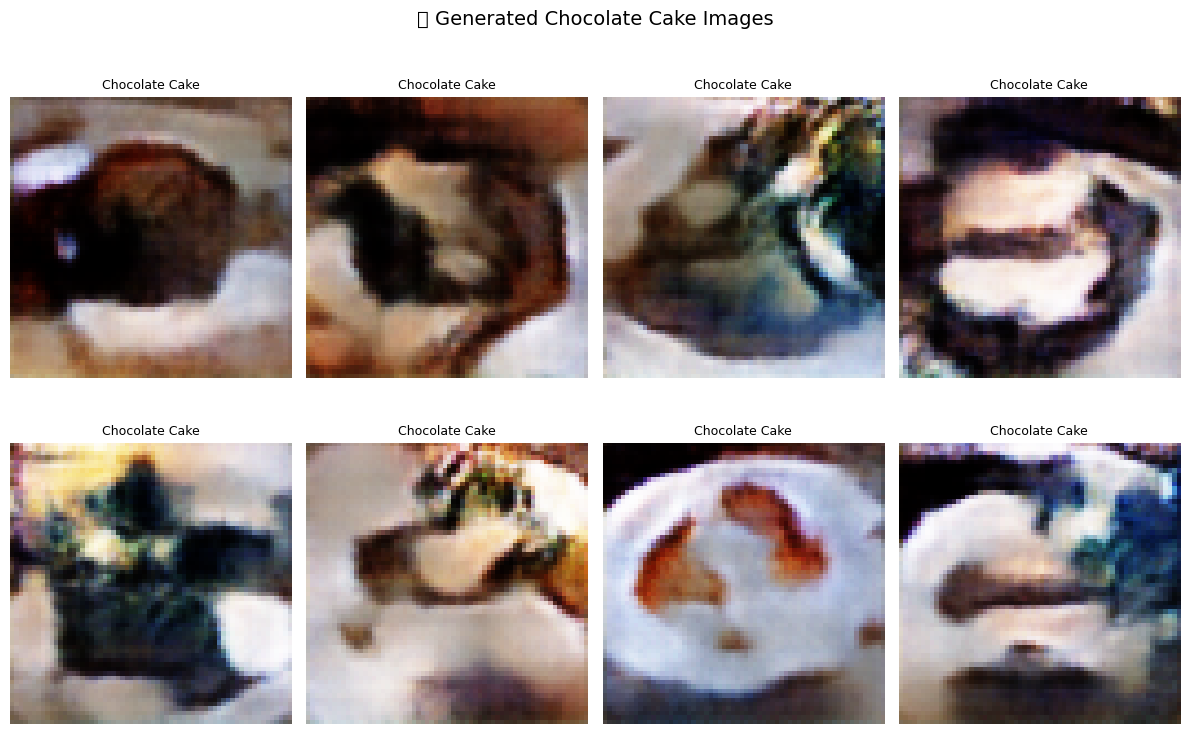

In [41]:
CATEGORY = "chocolate_cake"
NUM_IMAGES = 8

result = generate_food_image(CATEGORY, num_images=NUM_IMAGES)
if result is not None:
    images, cat_name = result
    labels = [cat_name.replace('_', ' ').title()] * NUM_IMAGES
    show_tensor_images(images, num_images=NUM_IMAGES, nrow=4,
                      labels=labels, figsize=(12, 8),
                      title=f"Generated {cat_name.replace('_', ' ').title()} Images")


CONDITIONAL GAN FOOD IMAGE GENERATOR 

Available food categories:
  0: apple_pie                  1: baby_back_ribs             2: baklava                  
  3: beef_carpaccio             4: beef_tartare               5: beet_salad               
  6: beignets                   7: bibimbap                   8: bread_pudding            
  9: breakfast_burrito         10: bruschetta                11: caesar_salad             
 12: cannoli                   13: caprese_salad             14: carrot_cake              
 15: ceviche                   16: cheesecake                17: cheese_plate             
 18: chicken_curry             19: chicken_quesadilla        20: chicken_wings            
 21: chocolate_cake            22: chocolate_mousse          23: churros                  
 24: clam_chowder              25: club_sandwich             26: crab_cakes               
 27: creme_brulee              28: croque_madame             29: cup_cakes                
 30: deviled_eggs      

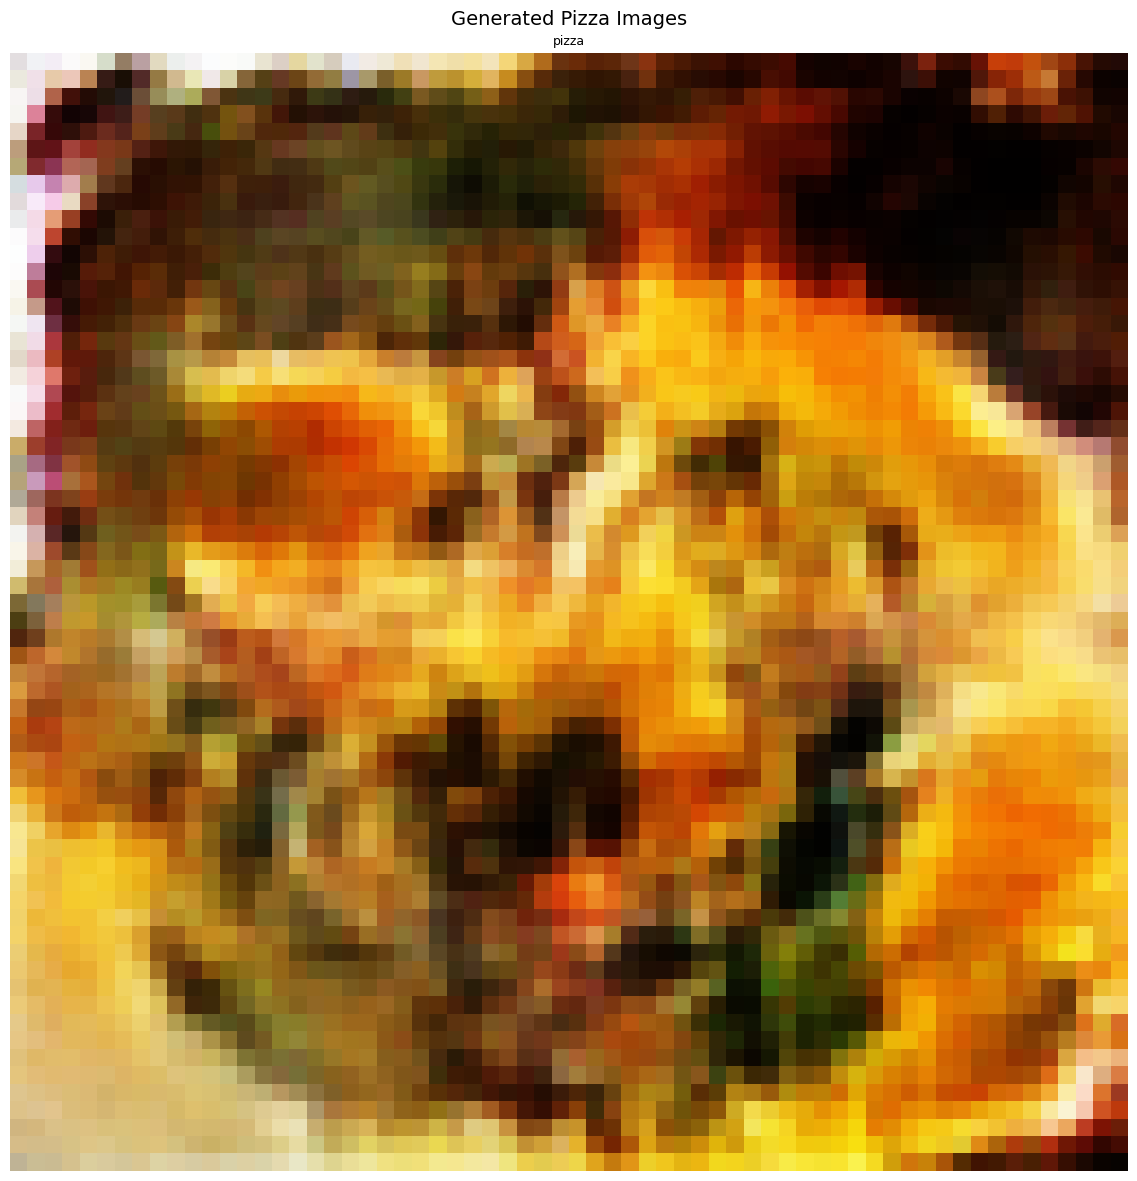

In [44]:
interactive_generate()

In [42]:
os.makedirs('saved_models', exist_ok=True)

torch.save({
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'g_optimizer_state_dict': G_optimizer.state_dict(),
    'd_optimizer_state_dict': D_optimizer.state_dict(),
    'epoch': EPOCHS,
    'history': history,
    'noise_dim': NOISE_DIM,
    'embed_dim': EMBED_DIM,
    'num_classes': NUM_CLASSES,
    'label_names': LABEL_NAMES,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label
}, 'saved_models/food101_cgan.pth')

print("Model saved to 'saved_models/food101_cgan.pth'")

Model saved to 'saved_models/food101_cgan.pth'


In [43]:
def load_cgan_and_generate(checkpoint_path, category_name, num_images=4):

    checkpoint = torch.load(checkpoint_path)

    generator = ConditionalGenerator(
        checkpoint['noise_dim'],
        checkpoint['num_classes'],
        checkpoint['embed_dim']
    ).to(device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()

    label_to_idx = checkpoint['label_to_idx']

    category_name = category_name.lower().strip().replace(' ', '_')
    if category_name not in label_to_idx:
        print(f"Category '{category_name}' not found!")
        return None

    class_idx = label_to_idx[category_name]

    with torch.no_grad():
        noise = torch.randn(num_images, checkpoint['noise_dim'], device=device)
        labels = torch.full((num_images,), class_idx, dtype=torch.long, device=device)
        images = generator(noise, labels)

    return images

print("Load function ready for future use!")

Load function ready for future use!
